## № 5

Model:
$$
x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1},\quad z_{t}=x_{t} + \eta_{t}
$$
with $P(\epsilon_t)=\mathcal{N}(0,\sigma)$, $P(\eta_t)=\mathcal{N}(0,\rho)$

Consider the filtering and smoothing problems for the the set of observations $z_t$ (the model is specified by $\sigma=1,\rho=2$)

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('9.5.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.keys()

dict_keys(['u', 'z'])

### Part 1

Compute the filtered trajectory for $x_t$.

Воспользуемся кодом с лекции:

In [4]:
def kalman_filter(u, z, sigma, rho):
    T = len(z)
    err2 = np.zeros(T)
    x_est = np.zeros(T)
    K = np.zeros(T)
    err2[0] = rho**2
    K[0] = 1
    x_est[0] = z[0]

    for i in range(1, T):
        K[i] = (err2[i-1] + sigma**2)/(err2[i-1] + sigma**2 + rho**2)
        err2[i] = rho**2 * K[i]
        x_est[i] = K[i] * z[i] + (1-K[i])*(x_est[i-1]+u[i-1])

    return {'x': x_est, 'err': np.sqrt(err2), 'K': K}

In [5]:
filter_result = kalman_filter(**data, sigma = 1, rho = 2)

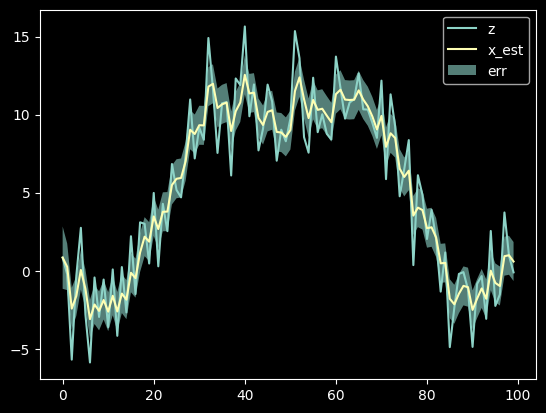

In [6]:
plt.plot(data['z'], label = 'z')
plt.plot(filter_result['x'], label = 'x_est')
plt.fill_between(np.arange(len(data['z'])), filter_result['x'] - filter_result['err'], filter_result['x'] + filter_result['err'], alpha = 0.6, label = 'err')
plt.legend()

### Part 2

Compute the most likely full trajectory of the hidden variable $x_t$. In order to do so, consider the likelihood $P(x_0,x_1...,x_T|z_0,...,z_T)$ and maximize it over $\mathbf{x}$. This maximization reduces to solving a system of linear equations. Solve this system numerically and plot the resulting $\hat {\mathbf{x}}$ as a function of time. Compare computation complexity (as function of $T$) of this approach to smoothing and the filtering which you did in the previous step.

Решение

Мы знаем, что
$$
\begin{aligned}
& x_t - x_{t-1} - u_{t-1} \sim \mathcal{N}(0, \sigma) \\
& z_t - x_t \sim \mathcal{N}(0, \rho)
\end{aligned}
$$

Функция правдоподобия
$$
L \sim \prod_t 
\exp\biggl(-\frac{(x_t - x_{t-1} - u_{t-1})^2}{2\sigma^2}\biggr)
\exp\biggl(-\frac{(z_t - x_t)^2}{2\rho^2}\biggr)
$$

Логарифм функции правдоподобия
$$
\ln L = 
- \sum_t \frac{(x_t - x_{t-1} - u_{t-1})^2}{2\sigma^2}
- \sum_t \frac{(z_t - x_t)^2}{2\rho^2}
+ \text{const}
$$

Найдем максимум логарифма функции правдоподобия
$$
\frac{\partial \ln L}{\partial x_t} =
\frac{x_{t-1} - x_t + u_{t-1}}{\sigma^2} +
\frac{x_{t+1} - x_t - u_t}{\sigma^2} +
\frac{z_t - x_t}{\rho^2} = 0
$$

Если записать это в виде системы уравнений, то получим
$$
\begin{pmatrix}
\frac{1}{\sigma^2} + \frac{1}{\rho^2} & -\frac{1}{\sigma^2} & 0 & \cdots & 0 \\
-\frac{1}{\sigma^2} & \frac{2}{\sigma^2} + \frac{1}{\rho^2} & -\frac{1}{\sigma^2} & \cdots & 0 \\
0 & -\frac{1}{\sigma^2} & \frac{2}{\sigma^2} + \frac{1}{\rho^2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \frac{1}{\sigma^2} + \frac{1}{\rho^2}
\end{pmatrix}
\begin{pmatrix}
x_0 \\ x_1 \\ x_2 \\ \vdots \\ x_{T-1}
\end{pmatrix}
=
\begin{pmatrix}
\frac{0 - u_0}{\sigma^2} + \frac{z_0}{\rho^2} \\
\frac{u_0 - u_1}{\sigma^2} + \frac{z_1}{\rho^2} \\
\frac{u_1 - u_2}{\sigma^2} + \frac{z_2}{\rho^2} \\
\vdots \\
\frac{u_{T-2}}{\sigma^2} + \frac{z_{T-1}}{\rho^2}
\end{pmatrix}
$$

In [7]:
import scipy

In [10]:
def kalman_smoother(u, z, sigma, rho):
    main_diagonal = (2/sigma**2 + 1/rho**2) * np.ones(len(z))
    main_diagonal[0] = main_diagonal[-1] = 1/sigma**2 + 1/rho**2

    upper_diagonal = -1/sigma**2 * np.ones(len(z))
        # upper_diagonal[0]  will be ignored by scipy.linalg.solve_banded
    lower_diagonal = -1/sigma**2 * np.ones(len(z))
        # lower_diagonal[-1] will be ignored by scipy.linalg.solve_banded

    rhs = z/rho**2 + 1/sigma**2 * np.diff(u[:-1], prepend=0, append=0)

    return scipy.linalg.solve_banded((1, 1), [upper_diagonal, main_diagonal, lower_diagonal], rhs)

In [9]:
np.diff([1, 2, 3, 4, 5], prepend = 0)

array([1, 1, 1, 1, 1])

In [11]:
smooth_result = kalman_smoother(**data, sigma = 1, rho = 2)

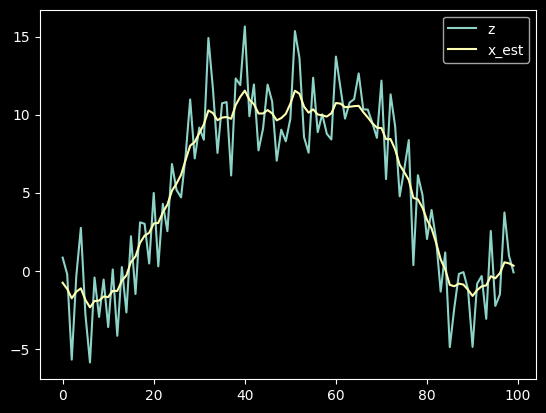

In [12]:
plt.plot(data['z'], label = 'z')
plt.plot(smooth_result, label = 'x_est')
plt.legend()

### Part 3

Compute the error bar around each point and plot the $2\sigma$ band around the max-likelihood estimation (it should be a function of time, too!). The error bar can be computed as follows:
$$
\textrm{err}_t^2 = \int (x_t -\hat x_t)^2P(x_0,x_1...,x_T|z_0,...,z_T)\Pi_{i=0}^T dx_i
$$

Решение

К счастью, можно обойтись без интегрирования.

Вспомним, что функция правдоподобия пропорциональна
$$
L \sim \prod_t 
\exp\biggl(-\frac{(x_t - x_{t-1} - u_{t-1})^2}{2\sigma^2}\biggr)
\exp\biggl(-\frac{(z_t - x_t)^2}{2\rho^2}\biggr)
$$
При фиксированных $z$ и $u$ это выражение можно привести к виду
$$
L \sim \exp\biggl(-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\biggr)
$$
И наша цель - найти $\mu$ и $\Sigma$.
Параметр $\mu$ мы уже нашли, найдя максимум функции $\ln L(x)$.

Параметр $\Sigma$ можно найти, инвертировав гессиан функции $\ln L(x)$:
$$
\frac{\partial^2 \ln L}{\partial x_i \partial x_j} \equiv -\Sigma^{-1}
$$

Гессиан совпадает с матрицей линейной системы, которую мы решали в предыдущем пункте. Нужно найти к ней обратную и взять диагональные элементы.

In [13]:
def kalman_cov(N, sigma, rho):
    main_diagonal = (2/sigma**2 + 1/rho**2) * np.ones(N)
    main_diagonal[0] = main_diagonal[-1] = 1/sigma**2 + 1/rho**2

    upper_diagonal = -1/sigma**2 * np.ones(N-1)
    lower_diagonal = -1/sigma**2 * np.ones(N-1)

    hessian = scipy.sparse.diags([upper_diagonal, main_diagonal, lower_diagonal], [1, 0, -1], format = 'csc')
    return scipy.sparse.linalg.inv(hessian)

In [14]:
errs2 = kalman_cov(len(data['z']), sigma = 1, rho = 2).diagonal()
errs2

array([1.56155281, 1.18992627, 1.05181998, 1.00049602, 0.98142267,
       0.97433451, 0.97170036, 0.97072144, 0.97035765, 0.97022246,
       0.97017221, 0.97015354, 0.9701466 , 0.97014403, 0.97014307,
       0.97014271, 0.97014258, 0.97014253, 0.97014251, 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 ,
       0.9701425 , 0.9701425 , 0.9701425 , 0.9701425 , 0.97014

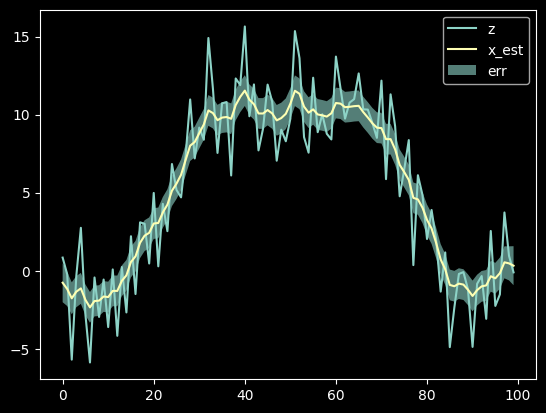

In [15]:
plt.plot(data['z'], label = 'z')
plt.plot(smooth_result, label = 'x_est')
plt.fill_between(np.arange(len(data['z'])), smooth_result - np.sqrt(errs2), smooth_result + np.sqrt(errs2), alpha = 0.6, label = 'err')
plt.legend()